In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Convolution Layer

(1, 3, 3, 3)
(1, 7, 7, 3)


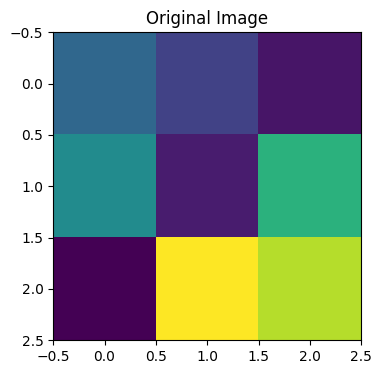

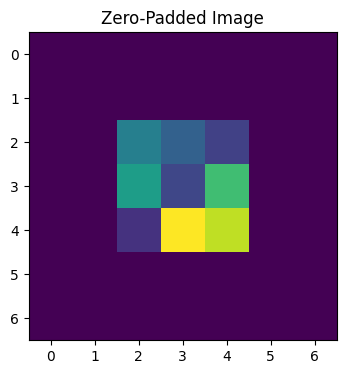

In [2]:
# @title Zero padding function
def zero_padder(X, pad):
    # Set the padding values for height and width
    h_pad, w_pad = pad, pad

    # Apply zero-padding to the input array X
    X_pad = np.pad(X, ((0, 0), (h_pad, h_pad), (w_pad, w_pad), (0, 0)), mode="constant", constant_values=0)

    return X_pad

# Testing
np.random.seed(1)

# Generate a random 3D array for testing
X_chk = np.random.rand(1, 3, 3, 3)

# Pad the array using the zero_padder function
X_pad = zero_padder(X_chk, pad=2)

print(X_chk.shape)
print(X_pad.shape)
# Display the original and zero-padded images for visualization
plt.figure(figsize=(4, 4))
plt.imshow(X_chk[0, :, :, 0])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(X_pad[0, :, :, 0])
plt.title('Zero-Padded Image')
plt.show()


In [3]:
# @title Windowing function

def windowing(window, kernel, bias):
    # Add a new axis to the window for element-wise multiplication with the kernel
    window_with_new_axis = window[:, :, :, :, np.newaxis]

    # Perform element-wise multiplication with the kernel and sum along specified axes
    ans = np.sum(window_with_new_axis * kernel, axis=(1, 2, 3))

    # Add the bias, squeezing to remove dimensions with size 1
    ans += bias.squeeze()

    return ans

# Testing
np.random.seed(1)

# Generate random input values for testing
window = np.random.rand(10, 2, 2, 3)
kernel = np.random.rand(2, 2, 3, 8)
bias = np.random.rand(1, 1, 1, 8)

# Test the windowing function
result = windowing(window, kernel, bias)

# Display the results with additional information
print("Input Window shape:", window.shape)
print("Convolutional Kernel shape:", kernel.shape)
print("Bias shape:", bias.shape)
print("Result shape:", result.shape)
print("Result values:")
print(result)

Input Window shape: (10, 2, 2, 3)
Convolutional Kernel shape: (2, 2, 3, 8)
Bias shape: (1, 1, 1, 8)
Result shape: (10, 8)
Result values:
[[2.11483369 3.06371852 2.72579397 3.21436413 1.97537873 1.58797799
  2.25426311 3.06628442]
 [2.63457822 3.97682035 3.62585275 4.68333082 2.28678247 2.02598448
  2.75831217 4.0750302 ]
 [2.4598589  3.75108906 3.53199021 4.15418407 2.82878927 2.46092526
  2.97882759 3.58510194]
 [3.11783141 3.43023503 3.74967785 4.81609249 3.10090881 2.26981961
  3.88623786 4.85226469]
 [2.07230443 3.08646235 2.51908951 3.14969492 1.94378402 1.76689736
  1.67139618 3.27417858]
 [3.22061785 4.01114787 3.95197911 4.44668409 2.79746631 2.36187535
  2.60476443 3.4938863 ]
 [3.72936297 4.25974279 3.98317993 5.20024844 3.01665859 2.83426379
  3.89252606 4.12479491]
 [2.90725855 3.4872197  3.67859388 4.74848187 3.02521961 1.98509787
  3.31148234 4.16631379]
 [2.7993584  4.19973539 3.16767299 4.99117414 3.16030599 2.56064804
  3.00390276 4.64833641]
 [3.21274471 3.92710922 4.

In [4]:
# @title forward propogation

def conv_forward(X, kernel, bias, stride=1, pad=0):
    samples, ht, wd, inp_C = X.shape
    k_ht, k_wd, inp_C, out_C = kernel.shape

    # Calculate the output height and width
    out_ht = int(((ht - k_ht + 2 * pad) / stride) + 1)
    out_wd = int(((wd - k_wd + 2 * pad) / stride) + 1)

    # Initialize the output array
    out_X = np.zeros((samples, out_ht, out_wd, out_C), dtype=X.dtype)

    # Pad the input
    pad_X = zero_padder(X, pad)

    # Loop over the output height and width
    for h in range(out_ht):
        for w in range(out_wd):
            st_h, st_w = h * stride, w * stride
            ed_h, ed_w = st_h + k_ht, st_w + k_wd

            # Extract the window from the padded input
            window = pad_X[:, st_h:ed_h, st_w:ed_w, :]

            # Apply the windowing operation using the kernel and add bias
            out_X[:, h, w, :] = windowing(window, kernel, bias)

    return out_X

# Testing
np.random.seed(1)

# Generate random input data, convolutional kernel, and bias for testing
X = np.random.randn(10, 4, 4, 3)
kernel = np.random.randn(2, 2, 3, 8)
bias = np.random.randn(1, 1, 1, 8)

# Perform the convolutional layer forward pass
X_out = conv_forward(X, kernel, bias, stride=2, pad=2)

# Display results with additional information
print("Input data shape:", X.shape)
print("Convolutional Kernel shape:", kernel.shape)
print("Bias shape:", bias.shape)
print("Output shape:", X_out.shape)
print("Output mean:", np.mean(X_out))
print("Output value at [3, 2, 1]:", X_out[3, 2, 1])


Input data shape: (10, 4, 4, 3)
Convolutional Kernel shape: (2, 2, 3, 8)
Bias shape: (1, 1, 1, 8)
Output shape: (10, 4, 4, 8)
Output mean: 0.04899520352885581
Output value at [3, 2, 1]: [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]


In [5]:
# @title backward propogation

def conv_backward(d_X, X_inp, kernel, bias, stride=1, pad=0):
    # Initialize shapes
    samples, in_ht, in_wd, inp_C = X_inp.shape
    k_ht, k_wd, inp_C, C = kernel.shape
    samples, ht, wd, C = d_X.shape

    # Initialize gradients
    d_X_inp = np.zeros_like(X_inp)
    d_kern = np.zeros_like(kernel)
    d_bias = np.zeros_like(bias)

    # Pad input and corresponding gradients
    pad_X_inp = zero_padder(X_inp, pad)
    d_pad_X_inp = zero_padder(d_X_inp, pad)

    for i in range(samples):
        x_inp_pad = pad_X_inp[i]
        dx_inp_pad = d_pad_X_inp[i]

        for h in range(ht):
            for w in range(wd):
                st_h, st_w = h, w
                ed_h, ed_w = st_h + k_ht, st_w + k_wd

                # Extract window from padded input
                window = x_inp_pad[st_h:ed_h, st_w:ed_w, :]

                # Update gradients
                dx_inp_pad[st_h:ed_h, st_w:ed_w, :] += np.sum(np.multiply(kernel[:, :, :, :], d_X[i, h, w, :]), axis=3)
                d_kern[:, :, :, :] += window[:, :, :, np.newaxis] * d_X[i, h, w, :][np.newaxis, np.newaxis, np.newaxis, :]
                d_bias[:, :, :, :] += d_X[i, h, w, :]

        # Remove padding from input gradients
        d_X_inp[i, :, :, :] = dx_inp_pad[pad:-pad, pad:-pad, :]

    return d_X_inp, d_kern, d_bias

# Test the backward pass
np.random.seed(1)

X = np.random.randn(10, 4, 4, 3)
kernel = np.random.randn(2, 2, 3, 8)
bias = np.random.randn(1, 1, 1, 8)

X_out = conv_forward(X, kernel, bias, stride=2, pad=2)
dX, dW, db = conv_backward(X_out, X, kernel, bias, stride=2, pad=2)

# Display results with additional information
print("dX shape =", dX.shape)
print("dX_mean =", np.mean(dX))
print()
print("dW shape =", dW.shape)
print("dW_mean =", np.mean(dW))
print()
print("db shape =", db.shape)
print("db_mean =", np.mean(db))

dX shape = (10, 4, 4, 3)
dX_mean = 0.634770447265474

dW shape = (2, 2, 3, 8)
dW_mean = 1.5572657428497354

db shape = (1, 1, 1, 8)
db_mean = 7.839232564616838


## Pooling layer

### Forward propogation

In [6]:
# @title Pooling mask for forward propagation

def mask_forward(window, mode):
    # Apply pooling based on the specified mode
    if mode == 'min':
        return np.min(window, axis=(1, 2))
    elif mode == 'average':
        return np.mean(window, axis=(1, 2))
    elif mode == 'max':
        return np.max(window, axis=(1, 2))
    else:
        # Raise an error for unsupported pooling mode
        raise ValueError("Unsupported pooling mode. Use 'min', 'average', or 'max'.")

#Testing
np.random.seed(1)

# Generate random window data
window = np.random.rand(5, 4, 3, 3)

# Test pooling for different modes
modes = ['min', 'average', 'max']
for mode in modes:
    # Apply pooling and display results
    result = mask_forward(window, mode)
    print(f"Pooling mode: {mode}")
    print(f"Result shape: {result.shape}")
    print(f"Result values: {result}")
    print()

Pooling mode: min
Result shape: (5, 3)
Result values: [[3.90547832e-02 1.46755891e-01 1.14374817e-04]
 [1.02334429e-01 4.99534589e-02 1.82882773e-02]
 [1.14745973e-01 1.58212428e-02 2.87032703e-03]
 [1.98801338e-02 1.86472894e-02 2.83064880e-02]
 [1.85762022e-02 6.63348344e-02 1.25559802e-02]]

Pooling mode: average
Result shape: (5, 3)
Result values: [[0.41457965 0.46801711 0.4575147 ]
 [0.46139656 0.53233224 0.41953747]
 [0.55307042 0.61685079 0.50685616]
 [0.39242965 0.61197725 0.43952412]
 [0.42703433 0.46394074 0.44949488]]

Pooling mode: max
Result shape: (5, 3)
Result values: [[0.96826158 0.89460666 0.95788953]
 [0.75014431 0.98886109 0.94459476]
 [0.96484005 0.94948926 0.92943723]
 [0.92302454 0.99732285 0.96959575]
 [0.98861615 0.96727633 0.97001999]]



In [7]:
# @title Pooling forward propagation step

def pool_forward(X, kernel_size, stride=1, mode='max'):
    # Extract dimensions from input data
    samples, ht, wd, tot_C = X.shape
    k_sz = kernel_size

    # Calculate output dimensions
    out_ht = int(((ht - k_sz) / stride) + 1)
    out_wd = int(((wd - k_sz) / stride) + 1)

    # Initialize output array
    out_X = np.zeros((samples, out_ht, out_wd, tot_C), dtype=X.dtype)

    # Iterate over output dimensions
    for h in range(out_ht):
        for w in range(out_wd):
            st_h, st_w = h * stride, w * stride
            ed_h, ed_w = st_h + k_sz, st_w + k_sz

            # Extract window from input
            window = X[:, st_h:ed_h, st_w:ed_w, :]

            # Apply pooling to the window based on the specified mode
            if mode == 'min':
                out_X[:, h, w, :] = np.min(window, axis=(1, 2))
            elif mode == 'average':
                out_X[:, h, w, :] = np.mean(window, axis=(1, 2))
            elif mode == 'max':
                out_X[:, h, w, :] = np.max(window, axis=(1, 2))
            else:
                raise ValueError("Unsupported pooling mode. Use 'min', 'average', or 'max'.")

    return out_X


# Testing
np.random.seed(1)

X = np.random.randn(2, 4, 4, 3)
#testing for both max, average and min
modes = ['max', 'average', 'min']

for mode in modes:
    result = pool_forward(X, 3, 2, mode=mode)
    print(f"mode = {mode}")
    print(f"X_{mode} =", result)
    print()

mode = max
X_max = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
X_average = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]

mode = min
X_min = [[[[-1.09989127 -0.7612069  -2.3015387 ]]]


 [[[-2.02220122 -1.1425182  -0.34934272]]]]



### Backward propogation

In [8]:
# @title Value distribution

def distribute_value(dz, shape):
    # Calculate the dimensions of the shape
    (ht, wd, c) = shape

    # Calculate the average value to distribute
    average = dz / (ht * wd)

    # Create an array with the specified shape, each element containing an equal portion of the input value
    result = np.ones(shape) * average

    return result

# Testing
np.random.seed(1)

# Test distribute_value with a more complex dz value
dz = np.random.randn(2, 2, 1)
shape = (2, 2, 1)
result = distribute_value(dz, shape)

# Display test results
print("Test distribute_value:")
print(f"dz = {dz}")
print(f"shape = {shape}")
print("Result:")
print(result)
print()

Test distribute_value:
dz = [[[ 1.62434536]
  [-0.61175641]]

 [[-0.52817175]
  [-1.07296862]]]
shape = (2, 2, 1)
Result:
[[[ 0.40608634]
  [-0.1529391 ]]

 [[-0.13204294]
  [-0.26824216]]]



In [9]:
# @title Mask Creation (max)

def mask_max(window):
    # Find the maximum value in the window along the specified axes
    max_value = np.max(window, axis=(0, 1), keepdims=True)

    # Create a binary mask indicating where the values are equal to the maximum
    result = (window == max_value)

    return result

# Testing
np.random.seed(1)

# Test mask_max with a sample window
window = np.array([[[1, 2], [3, 4]], [[2, 2], [1, 1]]])
result = mask_max(window)

# Display test results
print("Test mask_max:")
print("Window:")
print(window)
print("Result:")
print(result)
print()

Test mask_max:
Window:
[[[1 2]
  [3 4]]

 [[2 2]
  [1 1]]]
Result:
[[[False False]
  [ True  True]]

 [[False False]
  [False False]]]



In [10]:
# @title Mask Creation (min)

def mask_min(window):
    # Find the minimum value in the window along the specified axes
    min_value = np.min(window, axis=(0, 1), keepdims=True)

    # Create a binary mask indicating where the values are equal to the minimum
    result = (window == min_value)

    return result

# Testing
np.random.seed(1)

# Test mask_min with a sample window
window = np.array([[[1, 2], [3, 4]], [[2, 2], [1, 1]]])
result = mask_min(window)

# Display test results
print("Test mask_min:")
print("Window:")
print(window)
print("Result:")
print(result)
print()

Test mask_min:
Window:
[[[1 2]
  [3 4]]

 [[2 2]
  [1 1]]]
Result:
[[[ True False]
  [False False]]

 [[False False]
  [ True  True]]]



In [11]:
# @title Pooling backward propogation

def pool_backward(d_X, X_inp, stride, kernel_size, mode="max"):
    # Extract kernel size
    k_sz = kernel_size

    # Get input dimensions
    samples, in_ht, in_wd, inp_C = X_inp.shape
    d_X_inp = np.zeros_like(X_inp)

    # Get output dimensions
    samples, ht, wd, C = d_X.shape

    for i in range(samples):
        curr_x = X_inp[i]
        for h in range(ht):
            for w in range(wd):
                st_h, st_w = h, w
                ed_h, ed_w = st_h + k_sz, st_w + k_sz

                # Extract the window from the input
                window = curr_x[st_h:ed_h, st_w:ed_w, :]

                if mode == "max":
                    # Apply mask based on max pooling
                    mask = mask_max(window)
                    d_X_inp[i, st_h:ed_h, st_w:ed_w, :] += mask * d_X[i, h, w, :]

                elif mode == "average":
                    # Apply mask based on average pooling
                    shape = (k_sz, k_sz, 1)
                    d_X_inp[i, st_h:ed_h, st_w:ed_w, :] += distribute_value(d_X[i, h, w, :], shape)

                elif mode == "min":
                    # Apply mask based on min pooling
                    mask = mask_min(window)
                    d_X_inp[i, st_h:ed_h, st_w:ed_w, :] += mask * d_X[i, h, w, :]

    return d_X_inp

# Testing
np.random.seed(1)

X = np.random.randn(5, 5, 3, 2)
d_X = np.random.randn(5, 4, 2, 2)

# Test modes: max, average, min
modes = ['max', 'average', 'min']

for mode in modes:
    d_X_out = pool_backward(d_X, stride=1, kernel_size=2, X_inp=X, mode=mode)
    print(f"mode = {mode}")
    print('mean of dA = ', np.mean(d_X))
    print(f'dA_prev_{mode}[1,1] = ', d_X_out[1, 1])
    print()

mode = max
mean of dA =  0.14571390272918056
dA_prev_max[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev_average[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]

mode = min
mean of dA =  0.14571390272918056
dA_prev_min[1,1] =  [[ 0.3394185   0.        ]
 [ 0.          0.        ]
 [ 2.52832571 -2.1449957 ]]

